# **Proyecto final Deep Learning Alba ZÚÑIGA ASPAS**

Comenzamos instalando tres librerías, las vamos a utilizar durante la práctica. TensorFlow, Keras (es parte de TensorFlow) y kaggle para la descarga del conjunto de datos.

In [ ]:
!pip install tensorflow keras kaggle

In [ ]:
from google.colab import files
files.upload() # donde cargo el archivo kaggle.json para la API y poder descargar el conjunto de datos

In [ ]:
# creamos el directorio oculto donde copiamos el json y se otorgan permisos de lectura y escritura solo para mi usuario en este caso
# esto asegura que la biblioteca de Kaggle pueda autenticarse correctamente usando la API Key para descargar datasets
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d stevezhenghp/airbnb-price-prediction
!unzip airbnb-price-prediction.zip

Dataset URL: https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction
License(s): unknown
airbnb-price-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  airbnb-price-prediction.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
import pandas as pd

# Cargamos el archivo CSV
df = pd.read_csv('train.csv')

# Mostramos las primeras filas del df
print(df.head())

         id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
3  13418779   6.620073         House  Entire home/apt   
4   3808709   4.744932     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   

   bed_type cancellation_policy  cleaning_fee  ...   latitude   longitude  \
0  Real Bed              strict          True  ...  40.696524  -73.991617   
1  Real Bed     

In [ ]:
# información general del DataFrame
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [ ]:
# estadísticas descriptivas de las columnas numéricas
print(df.describe())


                 id     log_price  accommodates     bathrooms      latitude  \
count  7.411100e+04  74111.000000  74111.000000  73911.000000  74111.000000   
mean   1.126662e+07      4.782069      3.155146      1.235263     38.445958   
std    6.081735e+06      0.717394      2.153589      0.582044      3.080167   
min    3.440000e+02      0.000000      1.000000      0.000000     33.338905   
25%    6.261964e+06      4.317488      2.000000      1.000000     34.127908   
50%    1.225415e+07      4.709530      2.000000      1.000000     40.662138   
75%    1.640226e+07      5.220356      4.000000      1.000000     40.746096   
max    2.123090e+07      7.600402     16.000000      8.000000     42.390437   

          longitude  number_of_reviews  review_scores_rating      bedrooms  \
count  74111.000000       74111.000000          57389.000000  74020.000000   
mean     -92.397525          20.900568             94.067365      1.265793   
std       21.705322          37.828641              7.

In [ ]:
# verificamos si hay valores nulos
print(df.isnull().sum())


id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64


In [ ]:
#esta celda no tiene sentido ya que hemos podido ver que log_price no tiene nuelos. Pero eliminaríamos cualquier fila que tenga un valor nulo en la columna 'log_price', que es la columna objetivo
df = df.dropna(subset=['log_price'])


El enfoque va a ser naif. Vamos a ver que aunque he incluido la función de download_images yo he preferido hacer la opción de GDrive

In [ ]:
import cv2
import numpy as np
import imageio.v3 as io
from tqdm import tqdm
from typing import Optional, Union

def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None) -> tuple:
    """
    Download a list of images from url addresses, converting them to a specific canvas size.

    Args:
        paths: Paths or url addresses from which to load images.
        canvas: Desired image width and height.
        nb_channels: Channels in images (1 for B/W, 3 for RGB).
        max_imgs: Upper threshold in the number of images to download.

    Return:
        a tuple of:
        - image values
        - indices within the paths that were successful.
    """
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels), dtype=np.uint8)
    downloaded_idxs = []

    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:
            pass  # Unavailable url / conversion error

    return images[downloaded_idxs], downloaded_idxs


**Carga de Datos e Imágenes desde Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# cargamos el archivo CSV
data = pd.read_csv('/content/drive/MyDrive/keepcoding_DL/data_KC.csv', sep=';')

# cargamos las imágenes desde un archivo numpy
images = np.load('/content/drive/MyDrive/keepcoding_DL/images_KC.npy')

# mostramos las formas de los datos y las imágenes para verificación
print(data.shape, images.shape)

(2135, 30) (2135, 224, 224, 3)


Realizamos la conversión de log_price a Price utilizando numpy.exp. Una práctica común en análisis de datos y machine learning para manejar mejor la variabilidad en los datos y facilitar la interpretación de los resultados.

In [ ]:
import numpy as np

# convertimos los valores logarítmicos de precios a precios originales
data["Price"] = np.exp(data["log_price"])

# mostramos las primeras filas del DataFrame para verificar la conversión
print(data.head())



         id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2  13418779   6.620073         House  Entire home/apt   
3  12422935   4.442651     Apartment     Private room   
4  11825529   4.418841     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
3  {TV,"Wireless Internet",Heating,"Smoke detecto...             2        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             3        1.0   

   bed_type cancellation_policy  cleaning_fee  ...   longitude  \
0  Real Bed              strict          True  ...  -73.991617   
1  Real Bed              strict       

Guardamos las imágenes y los datos procesados en Google Drive para futuros usos.

In [ ]:
# guardamos en GDrive
np.save('images_KC.npy', images)
data.to_csv('data_KC.csv', sep=';', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Verificamos:

In [ ]:
!cp images_KC.npy /content/drive/MyDrive/keepcoding_DL/images_KC.npy
!cp data_KC.csv /content/drive/MyDrive/keepcoding_DL/data_KC.csv

!ls -lah images* data*  # comprobación

-rw-r--r-- 1 root root 2.8M Jul 11 20:32 data_KC.csv
-rw-r--r-- 1 root root 1.2G Jul 11 20:32 images_KC.npy


**Preparamos las etiquetas de clasificación**

Estadísticas como el conteo, la media, la desviación estándar, los valores mínimo y máximo, y los percentiles del 25%, 50% y 75%.

In [ ]:
data.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,Price
count,2.135000e+03,2135.000000,2135.000000,2128.000000,2135.000000,2135.000000,2135.000000,1589.000000,2131.000000,2132.000000,2135.000000
mean,1.135862e+07,4.762397,3.023888,1.192434,38.655781,-91.277067,19.352693,93.915670,1.211168,1.638368,154.805152
std,6.180578e+06,0.692962,2.029282,0.480190,2.968179,21.754768,35.414360,9.229399,0.788704,1.152432,158.297856
min,1.206800e+04,2.890372,1.000000,0.000000,33.343574,-122.508663,0.000000,20.000000,0.000000,1.000000,18.000000
25%,6.083100e+06,4.317488,2.000000,1.000000,34.190914,-118.343834,1.000000,92.000000,1.000000,1.000000,75.000000
50%,1.282450e+07,4.691348,2.000000,1.000000,40.677130,-74.000940,5.000000,96.000000,1.000000,1.000000,109.000000
75%,1.650152e+07,5.164786,4.000000,1.000000,40.741726,-73.950927,22.000000,100.000000,1.000000,2.000000,175.000000
max,2.118810e+07,7.467371,16.000000,5.500000,42.383869,-70.991861,318.000000,100.000000,7.000000,16.000000,1750.000000


Importaciones de bibliotecas necesarias para análisis estadístico, preprocesamiento de datos, división de datos en conjuntos de entrenamiento y prueba, y construcción de modelos de deep learning.

In [ ]:
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19, ResNet50

Clasificamos los precios en tres categorías diferentes para facilitar un análisis de clasificación en lugar de regresión.

<Axes: >

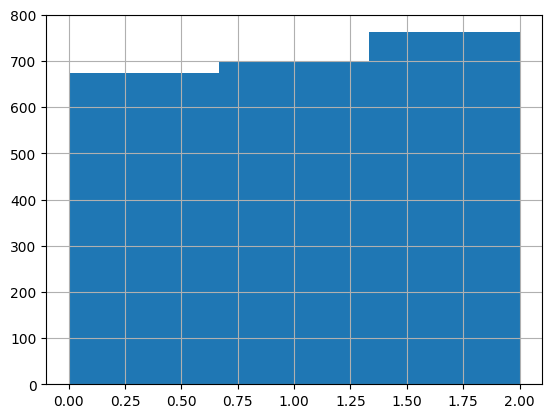

In [ ]:
y_class = []
for y in data['Price']:
  if y <= 80:
    y_class.append(0)
  elif 80 < y <= 140:
    y_class.append(1)
  else:
    y_class.append(2)
y_class = pd.Series(y_class)
y_class.hist(bins=3)


 Aseguramos que las etiquetas de clasificación (y_class) tengan el mismo índice que el DataFrame data.

In [ ]:
# reindexamos
y_class.index = data.index


Asignamos la columna Price a la variable ground_truth. Y mostramos histograma.

<Axes: >

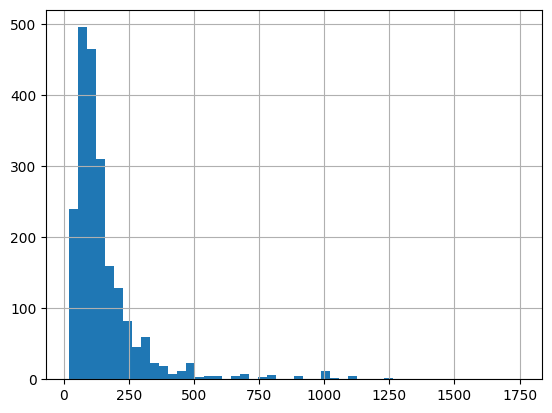

In [ ]:
ground_truth = data['Price']
ground_truth.hist(bins=50)

**División en train validation test**

In [ ]:
from sklearn.model_selection import train_test_split

# división inicial en entrenamiento y prueba
train_df, test_df, train_y, test_y = train_test_split(data, y_class,
                                                      test_size=0.25,
                                                      random_state=42,
                                                      shuffle=True,
                                                      stratify=y_class)

# división secundaria en entrenamiento y validación
train_df, val_df, train_y, val_y = train_test_split(train_df, train_y,
                                                    test_size=0.15,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=train_y)

# imprimimos formas de los conjuntos
print(train_df.shape, val_df.shape, test_df.shape)
print(train_y.shape, val_y.shape, test_y.shape)

# almacenamos los índices correspondientes a las particiones
train_idx, val_idx, test_idx = train_df.index, val_df.index, test_df.index

# verificamos la consistencia de las particiones
print(data.loc[train_idx].shape)
print(y_class.loc[train_idx].shape)


(1360, 30) (241, 30) (534, 30)
(1360,) (241,) (534,)
(1360, 30)
(1360,)


**Procesado de los datos**


*   Datos tabulares - numéricos
*   Datos tabulares - categóricos

In [ ]:
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating']
data[numerical_cols].shape

(2135, 8)

In [ ]:
for col in numerical_cols:
    data[col] = data[col].fillna(0)

data[numerical_cols].head(5)

,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating
0,3,1.0,1.0,1.0,40.696524,-73.991617,2,100.0
1,7,1.0,3.0,3.0,40.766115,-73.989040,6,93.0
2,4,1.0,2.0,2.0,37.772004,-122.431619,0,0.0
3,2,1.0,1.0,1.0,37.753164,-122.429526,3,100.0
4,3,1.0,1.0,1.0,33.980454,-118.462821,15,97.0


In [ ]:
# normalización de los datos numéricos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_num = pd.DataFrame(scaler.fit_transform(train_df[numerical_cols]), columns=numerical_cols)
val_num = pd.DataFrame(scaler.transform(val_df[numerical_cols]), columns=numerical_cols)
test_num = pd.DataFrame(scaler.transform(test_df[numerical_cols]), columns=numerical_cols)

numerical_data = pd.concat([train_num, val_num, test_num], axis=0)
numerical_data.index = data.index
numerical_data.shape


(2135, 8)

Vamos con los categóricos

In [ ]:
categorical_cols = ['property_type', 'room_type', 'cancellation_policy']
data[categorical_cols].head(5)

,property_type,room_type,cancellation_policy
0,Apartment,Entire home/apt,strict
1,Apartment,Entire home/apt,strict
2,House,Entire home/apt,flexible
3,Apartment,Private room,strict
4,Apartment,Entire home/apt,moderate


In [ ]:
# conversión a variables dummy (one-hot encoding)

property_type = pd.get_dummies(data[['property_type']], prefix='property_type')
room_type = pd.get_dummies(data[['room_type']], prefix='room_type')
canc_pol = pd.get_dummies(data['cancellation_policy'], prefix='cancellation_policy')

categorical_data = pd.concat([property_type, room_type, canc_pol], axis=1, join='inner')
categorical_data.shape


(2135, 27)

**Juntamos ambos tipos de datos**

Concatenamos las columnas numéricas normalizadas y las columnas categóricas codificadas en un solo DataFrame. Generamos pues un conjunto de datos final que combina todas las características que se utilizarán para entrenar el modelo.

In [ ]:
data = pd.concat([numerical_data, categorical_data], axis=1)
data


,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,property_type_Apartment,property_type_Bed & Breakfast,...,property_type_Timeshare,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,-0.510926,1.701672,-0.248957,-0.565363,0.674113,0.772022,-0.350096,-0.750117,True,False,...,False,False,False,True,False,False,False,False,True,False
1,-1.011184,-0.390914,-0.248957,-0.565363,0.685177,0.769096,-0.558351,NaN,True,False,...,False,False,False,True,False,False,False,False,True,False
2,0.489591,-0.390914,-0.248957,1.207762,-1.531462,-1.289263,-0.171592,0.634655,False,False,...,False,False,False,True,False,False,True,False,False,False
3,-0.510926,-0.390914,-0.248957,-0.565363,0.676719,0.772465,-0.528601,-1.343591,True,False,...,False,False,False,False,True,False,False,False,True,False
4,-0.510926,-0.390914,-0.248957,-0.565363,0.680630,0.770465,-0.558351,NaN,True,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,0.989850,-0.390914,-0.248957,-0.565363,0.081680,0.627479,-0.350096,0.041181,True,False,...,False,False,False,True,False,False,False,False,True,False
2131,-0.010667,-0.390914,-0.248957,0.321199,-0.298890,-1.475593,-0.171592,0.140093,True,False,...,False,False,False,True,False,False,False,False,True,False
2132,-0.010667,-0.390914,1.007861,0.321199,0.678422,0.772339,2.000212,0.041181,False,False,...,False,True,False,True,False,False,False,False,True,False
2133,-0.510926,-0.390914,-0.248957,-0.565363,-0.311403,-1.474293,-0.439348,0.140093,True,False,...,False,False,False,True,False,False,False,True,False,False


**Procesado de valores NaN**

In [ ]:
data.isna().sum()

accommodates                             0
bathrooms                                7
bedrooms                                 4
beds                                     3
latitude                                 0
longitude                                0
number_of_reviews                        0
review_scores_rating                   546
property_type_Apartment                  0
property_type_Bed & Breakfast            0
property_type_Boat                       0
property_type_Boutique hotel             0
property_type_Bungalow                   0
property_type_Camper/RV                  0
property_type_Castle                     0
property_type_Condominium                0
property_type_Dorm                       0
property_type_Guest suite                0
property_type_Guesthouse                 0
property_type_Hostel                     0
property_type_House                      0
property_type_In-law                     0
property_type_Loft                       0
property_ty

Rellenamos los valores nulos en las columnas seleccionadas con la media de las otras muestras de esa columna. Así tratamos los datos faltantes y evitamos que afecten negativamente al modelo.

In [ ]:
cols2fill = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating']
for col in cols2fill:
    data[col] = data[col].fillna(data[col].mean())
data.isna().sum()

accommodates                           0
bathrooms                              0
bedrooms                               0
beds                                   0
latitude                               0
longitude                              0
number_of_reviews                      0
review_scores_rating                   0
property_type_Apartment                0
property_type_Bed & Breakfast          0
property_type_Boat                     0
property_type_Boutique hotel           0
property_type_Bungalow                 0
property_type_Camper/RV                0
property_type_Castle                   0
property_type_Condominium              0
property_type_Dorm                     0
property_type_Guest suite              0
property_type_Guesthouse               0
property_type_Hostel                   0
property_type_House                    0
property_type_In-law                   0
property_type_Loft                     0
property_type_Other                    0
property_type_Se

**Clasificación basada en datos tabulares (FC layers)**

**Escalado [0, 1]**


**Normalización de datos entre 0 y 1**

In [ ]:
# vemos rangos máximos
data.max(axis=0)

accommodates                            6.492692
bathrooms                               9.025725
bedrooms                                7.291955
beds                                   12.733078
latitude                                1.240301
longitude                               0.907846
number_of_reviews                       8.902383
review_scores_rating                    0.634655
property_type_Apartment                     True
property_type_Bed & Breakfast               True
property_type_Boat                          True
property_type_Boutique hotel                True
property_type_Bungalow                      True
property_type_Camper/RV                     True
property_type_Castle                        True
property_type_Condominium                   True
property_type_Dorm                          True
property_type_Guest suite                   True
property_type_Guesthouse                    True
property_type_Hostel                        True
property_type_House 

In [ ]:
# escalamos todas las características en el rango [0, 1].
mm_scaler = MinMaxScaler()
cols = data.columns

train_X = pd.DataFrame(mm_scaler.fit_transform(data.loc[train_idx]), columns=cols)
val_X = pd.DataFrame(mm_scaler.transform(data.loc[val_idx]), columns=cols)
test_X = pd.DataFrame(mm_scaler.transform(data.loc[test_idx]), columns=cols)

# verificamos
train_X.max(axis=0)


accommodates                           1.0
bathrooms                              1.0
bedrooms                               1.0
beds                                   1.0
latitude                               1.0
longitude                              1.0
number_of_reviews                      1.0
review_scores_rating                   1.0
property_type_Apartment                1.0
property_type_Bed & Breakfast          1.0
property_type_Boat                     0.0
property_type_Boutique hotel           1.0
property_type_Bungalow                 1.0
property_type_Camper/RV                1.0
property_type_Castle                   1.0
property_type_Condominium              1.0
property_type_Dorm                     1.0
property_type_Guest suite              1.0
property_type_Guesthouse               1.0
property_type_Hostel                   0.0
property_type_House                    1.0
property_type_In-law                   1.0
property_type_Loft                     1.0
property_ty

**Clasificación con datos tabulares**

**Conversión de etiquetas a one-hot**

In [ ]:
# convertimos las etiquetas de clase en formato one-hot encoding necesario para que la función de pérdida categorical_crossentropy pueda ser utilizada en la clasificación
train_y_cls = to_categorical(y_class.loc[train_idx])
val_y_cls = to_categorical(y_class.loc[val_idx])
test_y_cls = to_categorical(y_class.loc[test_idx])

**Creación y entrenamiento del modelo**

In [ ]:
# definimos el modelo:
nb_out = train_y_cls.shape[1]
classifier1D = Sequential()
classifier1D.add(Dense(64, input_shape=(data.shape[1],), activation='relu'))
classifier1D.add(Dense(32, activation='relu'))
classifier1D.add(Dense(8, activation='relu'))
classifier1D.add(Dense(nb_out, activation='softmax'))
# compilamos el modelo:
classifier1D.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# resumen del modelo:
classifier1D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2304      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 3)                 27        
                                                                 
Total params: 4675 (18.26 KB)
Trainable params: 4675 (18.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Entrenamiento del modelo**

El modelo se entrena durante 30 épocas con un tamaño de lote de 32. Los datos de validación se utilizan para monitorear la precisión y la pérdida durante el entrenamiento.

In [ ]:
EPOCHS = 30
BS = 32

H = classifier1D.fit(x=train_X, y=train_y_cls, batch_size=BS, epochs=EPOCHS,
          validation_data=(val_X, val_y_cls), shuffle=True, verbose=1)


Epoch 1/30
43/43 [==============================] - 4s 15ms/step - loss: 1.0364 - accuracy: 0.5250 - val_loss: 0.9742 - val_accuracy: 0.5685
Epoch 2/30
43/43 [==============================] - 0s 3ms/step - loss: 0.9261 - accuracy: 0.5875 - val_loss: 0.9431 - val_accuracy: 0.5768
Epoch 3/30
43/43 [==============================] - 0s 3ms/step - loss: 0.8994 - accuracy: 0.5904 - val_loss: 0.9353 - val_accuracy: 0.5768
Epoch 4/30
43/43 [==============================] - 0s 3ms/step - loss: 0.8866 - accuracy: 0.5904 - val_loss: 0.9306 - val_accuracy: 0.5768
Epoch 5/30
43/43 [==============================] - 0s 3ms/step - loss: 0.8797 - accuracy: 0.5904 - val_loss: 0.9263 - val_accuracy: 0.5768
Epoch 6/30
43/43 [==============================] - 0s 4ms/step - loss: 0.8682 - accuracy: 0.5934 - val_loss: 0.9312 - val_accuracy: 0.5726
Epoch 7/30
43/43 [==============================] - 0s 3ms/step - loss: 0.8668 - accuracy: 0.5949 - val_loss: 0.9212 - val_accuracy: 0.5768
Epoch 8/30
43/43 [=

Graficamos las curvas de pérdida y precisión tanto para los datos de entrenamiento como de validación a lo largo de las épocas. Esto nos ayuda a visualizar cómo está aprendiendo el modelo y si hay signos de sobreajuste.

[]

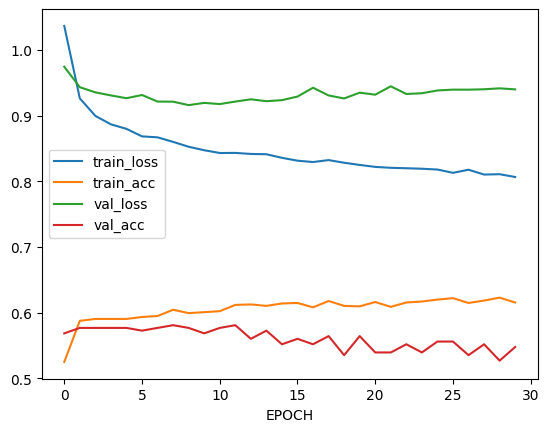

In [ ]:
import matplotlib.pyplot as plt
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['accuracy'], label='train_acc')
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('EPOCH')
plt.plot()


Evaluamos el modelo en el conjunto de datos de prueba para obtener la precisión y la pérdida final.

In [ ]:
loss, acc = classifier1D.evaluate(test_X, test_y_cls)
print(f'Loss={loss}, Acc={acc}')


17/17 [==============================] - 0s 2ms/step - loss: 0.8626 - accuracy: 0.5805
Loss=0.8625982403755188, Acc=0.5805243253707886


**Regresión con datos tabulares (FC layers)**

**Escalado de las etiquetas**

In [ ]:
# utilizamos MinMaxScaler para escalar los precios (ground_truth) entre 0 y 1 para todas las particiones de datos (entrenamiento, validación y prueba).
mm_scaler = MinMaxScaler()

train_y_reg = mm_scaler.fit_transform(
    ground_truth.loc[train_idx].values.reshape(-1, 1))
val_y_reg = mm_scaler.transform(
    ground_truth.loc[val_idx].values.reshape(-1, 1))
test_y_reg = mm_scaler.transform(
    ground_truth.loc[test_idx].values.reshape(-1, 1))

train_y_reg.shape, val_y_reg.shape, test_y_reg.shape


((1360, 1), (241, 1), (534, 1))

**Creación y entrenamiento del modelo de regresión**

Creamos un modelo Sequential de Keras.
Añadimos varias capas densas (Dense) con funciones de activación ReLU para capturar relaciones no lineales.
La capa final utiliza una función de activación lineal para la regresión.

In [ ]:
# definimos el modelo de regresión:
nb_out = train_y_reg.shape[1]
regressor1D = Sequential()
regressor1D.add(Dense(64, input_shape=(data.shape[1],), activation='relu'))
regressor1D.add(Dense(32, activation='relu'))
regressor1D.add(Dense(8, activation='relu'))
regressor1D.add(Dense(nb_out, activation='linear'))


In [ ]:
# compilamos
regressor1D.compile(loss='mean_squared_error', optimizer='adam')
regressor1D.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                2304      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4657 (18.19 KB)
Trainable params: 4657 (18.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Entrenamiento del modelo**

30 épocas con un tamaño de lote de 32. Los datos de validación se utilizan para monitorear la pérdida durante el entrenamiento.

In [ ]:
EPOCHS = 30
BS = 32

H = regressor1D.fit(x=train_X, y=train_y_reg, batch_size=BS, epochs=EPOCHS,
          validation_data=(val_X, val_y_reg), shuffle=True, verbose=1)


Epoch 1/30
43/43 [==============================] - 2s 12ms/step - loss: 0.0113 - val_loss: 0.0068
Epoch 2/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/30
43/43 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 4/30
43/43 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 5/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 6/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 7/30
43/43 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 8/30
43/43 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 9/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 10/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 11/30
43/43

**Evaluación del modelo y visualización de resultados**

[]

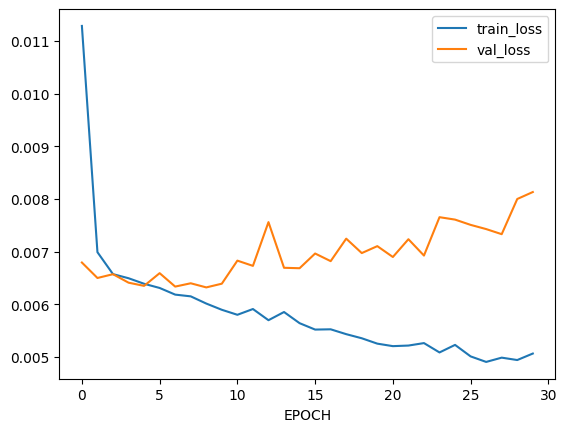

In [ ]:
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('EPOCH')
plt.plot()


**Evaluación y análisis del modelo**

Evaluamos el modelo en el conjunto de datos de prueba para obtener la pérdida final. También calculamos el coeficiente de correlación de Spearman para evaluar la relación entre los precios reales y predichos.

17/17 [==============================] - 0s 2ms/step
Loss (MSE)=0.009, Spearman Rank Correlation Coefficient=0.605
17/17 [==============================] - 0s 2ms/step


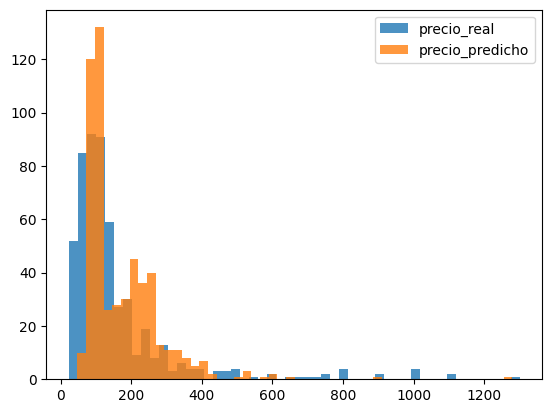

In [ ]:
# evaluamos el modelo en el conjunto de prueba:
loss = regressor1D.evaluate(test_X, test_y_reg)
rho = spearmanr(test_y_reg, regressor1D.predict(test_X))[0]
print(f'Loss (MSE)={loss:.3f}, Spearman Rank Correlation Coefficient={rho:.3f}')
# representación de precios reales y predichos:
test_prices = ground_truth.loc[test_idx]
raw_preds = regressor1D.predict(test_X)
rescaled_preds = mm_scaler.inverse_transform(raw_preds)

plt.hist(test_prices, bins=50, label="precio_real", alpha=0.8)
plt.hist(rescaled_preds, bins=50, label="precio_predicho", alpha=0.8)
plt.legend()
plt.show()


# **Definición del input shape y carga del modelo pre-entrenado:**

In [ ]:
input_shape = images[0].shape
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_resnet.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

**Transfer-learning**

**Congelar capas del modelo base y agregar capas de clasificación:**

In [ ]:
for layer in base_resnet.layers:
    layer.trainable = False

DROPOUT = 0.5
nb_out = train_y_cls.shape[1]
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(DROPOUT)(x)
x = Dense(nb_out, activation='softmax', name='predictions')(x)
classifier2D = Model(base_resnet.input, x)

classifier2D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier2D.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

**Entrenamiento del modelo:**

Hiperparámetros de entrenamiento: definimos el número de épocas (EPOCHS) y el tamaño del lote (BS).
Entrenamiento: entrenamos el modelo con los datos de entrenamiento y validamos con los datos de validación.

In [ ]:
EPOCHS = 5
BS = 32

H = classifier2D.fit(images[train_idx], train_y_cls, batch_size=BS, epochs=EPOCHS,
          validation_data=(images[val_idx], val_y_cls), shuffle=True, verbose=1)


Epoch 1/5
43/43 [==============================] - 391s 9s/step - loss: 1.2169 - accuracy: 0.3309 - val_loss: 1.1002 - val_accuracy: 0.3568
Epoch 2/5
43/43 [==============================] - 341s 8s/step - loss: 1.1086 - accuracy: 0.3544 - val_loss: 1.0982 - val_accuracy: 0.3859
Epoch 3/5
43/43 [==============================] - 372s 9s/step - loss: 1.0998 - accuracy: 0.3471 - val_loss: 1.0991 - val_accuracy: 0.3568
Epoch 4/5
43/43 [==============================] - 370s 9s/step - loss: 1.0977 - accuracy: 0.3324 - val_loss: 1.0970 - val_accuracy: 0.3527
Epoch 5/5
43/43 [==============================] - 371s 9s/step - loss: 1.0972 - accuracy: 0.3515 - val_loss: 1.0979 - val_accuracy: 0.3568


**Evaluación del modelo y visualización de las curvas de aprendizaje:**

[]

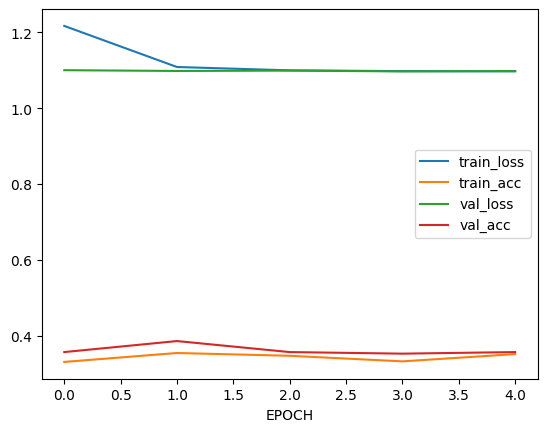

In [ ]:
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['accuracy'], label='train_acc')
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('EPOCH')
plt.plot()

**Evaluación final del modelo en el conjunto de test:**

In [ ]:
loss, acc = classifier2D.evaluate(images[test_idx], test_y_cls)
print(f'Loss={loss}, Acc={acc}')

17/17 [==============================] - 113s 6s/step - loss: 1.0951 - accuracy: 0.3577
Loss=1.0951205492019653, Acc=0.3576779067516327


**Regresión basada en imágenes (CNN)**

**Configuración del modelo de regresión:**

Similar al modelo de clasificación, pero la capa de salida usa una activación lineal y la pérdida es el error cuadrático medio.

In [ ]:
DROPOUT = 0.5
nb_out = train_y_reg.shape[1]
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(DROPOUT)(x)
x = Dense(nb_out, activation='linear', name='predictions')(x)
regressor2D = Model(base_resnet.input, x)

regressor2D.compile(optimizer='adam', loss='mean_squared_error')
regressor2D.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

**Entrenamiento del modelo de regresión:**

Similar al entrenamiento del modelo de clasificación, pero con las etiquetas de regresión.

In [ ]:
EPOCHS = 5
BS = 32

H = regressor2D.fit(x=images[train_idx], y=train_y_reg, batch_size=BS, epochs=EPOCHS,
          validation_data=(images[val_idx], val_y_reg), shuffle=True, verbose=1)


Epoch 1/5
43/43 [==============================] - 353s 8s/step - loss: 0.6784 - val_loss: 0.0333
Epoch 2/5
43/43 [==============================] - 374s 9s/step - loss: 0.0258 - val_loss: 0.0079
Epoch 3/5
43/43 [==============================] - 372s 9s/step - loss: 0.0099 - val_loss: 0.0075
Epoch 4/5
43/43 [==============================] - 389s 9s/step - loss: 0.0086 - val_loss: 0.0076
Epoch 5/5
43/43 [==============================] - 370s 9s/step - loss: 0.0084 - val_loss: 0.0075


[]

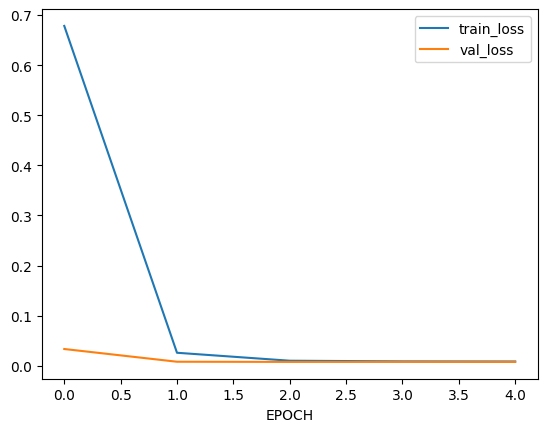

In [ ]:
# graficamos las pérdidas de entrenamiento y validación para la regresión.
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('EPOCH')
plt.plot()


Evaluamos el modelo con el conjunto de test y calculamos el coeficiente de correlación de Spearman para medir la relación entre los valores predichos y los reales.

17/17 [==============================] - 116s 7s/step
Loss (MSE)=0.010
Spearman Rank Correlation Coefficient=0.103
17/17 [==============================] - 115s 7s/step


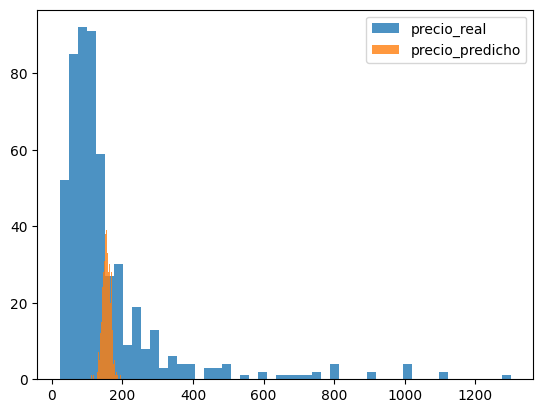

In [ ]:
loss = regressor2D.evaluate(images[test_idx], test_y_reg)
rho = spearmanr(test_y_reg, regressor2D.predict(images[test_idx]))[0]
print(f'Loss (MSE)={loss:.3f}\nSpearman Rank Correlation Coefficient={rho:.3f}')
# graficamos los precios reales y los predichos para visualizar la precisión del modelo:
test_prices = ground_truth.loc[test_idx]
raw_preds = regressor2D.predict(images[test_idx])
rescaled_preds = mm_scaler.inverse_transform(raw_preds)

plt.hist(test_prices, bins=50, label="precio_real", alpha=0.8)
plt.hist(rescaled_preds, bins=50, label="precio_predicho", alpha=0.8)
plt.legend()
plt.show()


# **Combinación de fuentes**


Vamos a considerar la combinación de modelos de clasificación, con dos enfoques principales: Late-Fusion y Early-Fusion.

**A) Late-Fusion (predicciones 1D + predicciones 2D)**

**Calculamos predicciones train/val/test de classifier1D**

In [ ]:
late_1d_train = classifier1D.predict(train_X)
late_1d_val = classifier1D.predict(val_X)
late_1d_test = classifier1D.predict(test_X)
print(late_1d_train.shape)

17/17 [==============================] - 0s 2ms/step
(1360, 3)


In [ ]:
# análogo para classifier2D
late_2d_train = classifier1D.predict(train_X)
late_2d_val = classifier1D.predict(val_X)
late_2d_test = classifier1D.predict(test_X)
print(late_2d_train.shape)

17/17 [==============================] - 0s 2ms/step
(1360, 3)


**Combinamos las predicciones y entrenar un SVM**

In [ ]:
from sklearn.svm import SVC
late_train_feats = np.concatenate((late_1d_train, late_2d_train), axis=1)
late_val_feats = np.concatenate((late_1d_val, late_2d_val), axis=1)
late_test_feats = np.concatenate((late_1d_test, late_2d_test), axis=1)

fusion_labels_train = np.concatenate((y_class.loc[train_idx], y_class.loc[val_idx]))
fusion_labels_test = y_class.loc[test_idx]

late_fuser = SVC(random_state=42)
late_fuser.fit(X=np.concatenate((late_train_feats, late_val_feats)), y=fusion_labels_train)
acc_late = late_fuser.score(X=late_test_feats, y=fusion_labels_test)
print(f"Late fusion achieves {acc_late:0.3f} accuracy")

Late fusion achieves 0.588 accuracy


**B) Early-Fusion (representación 1D + representación 2D)**

**Concatenar representaciones 1D**

Se concatenan las representaciones 1D de los conjuntos de entrenamiento y validación.

In [ ]:
early_1d_train = np.concatenate((train_X, val_X), axis=0)
print(early_1d_train.shape)

(1601, 35)


**Definimos un nuevo modelo para obtener características de 2D**

Tomamos una capa intermedia de classifier2D como extractor de características.

In [ ]:
last_conv = classifier2D.layers[-4].output
feature_extractor = Model(classifier2D.input, last_conv)
feature_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

**Obtenemos características de imágenes**

Obtenemos las características de las imágenes usando el extractor definido.

In [ ]:
early_2d_train = feature_extractor.predict(images[train_idx])
early_2d_val = feature_extractor.predict(images[val_idx])
early_2d_test = feature_extractor.predict(images[test_idx])
print(early_2d_train.shape)

17/17 [==============================] - 110s 7s/step
(1360, 2048)


**Reducimos dimensionalidad con PCA**

Dado que las características obtenidas de las imágenes pueden tener alta dimensionalidad, se reduce esta usando PCA.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
early_2d_train_pca = pca.fit_transform(early_2d_train)
early_2d_val_pca = pca.transform(early_2d_val)
early_2d_test_pca = pca.transform(early_2d_test)
print(early_2d_train_pca.shape)


(1360, 50)


**Combinamos ambas representaciones y entrenamos SVM**

Se combinan las representaciones 1D y las características PCA de las imágenes para entrenar y evaluar un modelo SVM.

In [ ]:
# Combinamos ambas representaciones (tabular + features-PCA)
early_train_feats = np.concatenate((early_1d_train, np.concatenate((early_2d_train_pca, early_2d_val_pca))), axis=1)
early_test_feats = np.concatenate((test_X, early_2d_test_pca), axis=1)

early_fuser = SVC(random_state=42)
early_fuser.fit(X=early_train_feats, y=fusion_labels_train)
acc_early = early_fuser.score(X=early_test_feats, y=fusion_labels_test)
print(f"Late fusion achieves {acc_early:0.3f} accuracy")

Late fusion achieves 0.601 accuracy


# **Cálculo de bandas de error**

Finalmente, calculamos las bandas de error para entender el margen de error de cada modelo:

In [ ]:
ci = lambda score, N: 1.96 * np.sqrt((score * (1 - score)) / N)
low_late_fusion = acc_late - ci(acc_late, len(test_X))
upper_late_fusion = acc_late + ci(acc_late, len(test_X))
low_early_fusion = acc_early - ci(acc_early, len(test_X))
upper_early_fusion = acc_early + ci(acc_early, len(test_X))

print(f"[LATE-fusion] accuracy con 95% error: [{low_late_fusion: .3f}, {upper_late_fusion: .3f}]")
print(f"[EARLY-fusion] accuracy con 95% error: [{low_early_fusion: .3f}, {upper_early_fusion: .3f}]")


[LATE-fusion] accuracy con 95% error: [ 0.546,  0.630]
[EARLY-fusion] accuracy con 95% error: [ 0.560,  0.643]


Esto da una idea del intervalo de confianza del 95% para la precisión de los modelos.